In [1]:
library(RPostgreSQL)
library(tidyverse)

Loading required package: DBI
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.4
✔ tibble  1.4.2     ✔ dplyr   0.7.4
✔ tidyr   0.8.0     ✔ stringr 1.2.0
✔ readr   1.1.1     ✔ forcats 0.2.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [2]:
data_dir <- file.path("..", "data")
sql_dir <- file.path("..", "sql")

In [3]:
drv <- dbDriver("PostgreSQL")
con <- dbConnect(drv, dbname = "mimic")
dbSendQuery(con, "set search_path=echo,public,mimiciii;")

<PostgreSQLResult>

In [4]:
sql <- readr::read_file(file.path(sql_dir, "tte-first.sql"))
sql

[1] "with pop_1 as (\n    select *\n    from population pop\n    left join (select icustay_id, hadm_id from icustays) icu using (icustay_id)\n)\n\n, pop_2 as (\n    select *\n    from pop_1\n    where angus = 1\n    and age >= 18\n    and icu_order = 1\n    and first_careunit in ('MICU', 'SICU')\n)\n\n, tte_1 as (\n    select hadm_id, min(chartdate) as echo_time\n    from noteevents\n    where lower(category) like 'echo'\n    and lower(description) like 'report'\n    group by hadm_id\n)\n\n, tte_2 as (\n    select pop.icustay_id, extract(day from (ec.echo_time - date_trunc('day', pop.intime))) as time_to_echo\n    from pop_2 pop left join tte_1 ec using (hadm_id)\n)\n\nselect * from tte_2;\n"

In [5]:
time_to_tte <- dbGetQuery(con, sql)
head(time_to_tte)
str(time_to_tte)

icustay_id,time_to_echo
200003,1
200014,2
200030,3
200033,NA
200036,NA
200047,3


'data.frame':	7184 obs. of  2 variables:
 $ icustay_id  : int  200003 200014 200030 200033 200036 200047 200068 200071 200075 200087 ...
 $ time_to_echo: num  1 2 3 NA NA 3 -11 20 2 1 ...


In [6]:
options(repr.plot.width = 6, repr.plot.height = 6)

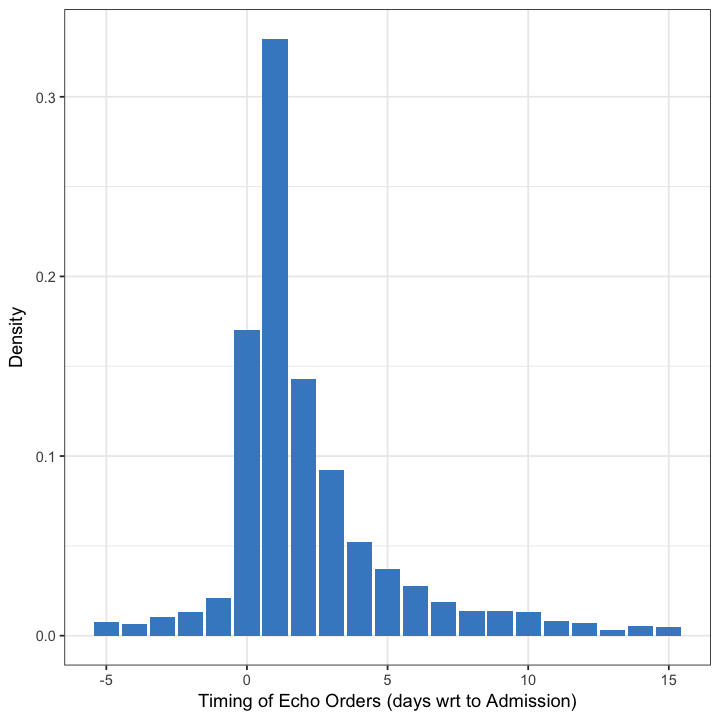

In [7]:
time_to_tte %>%
filter(!is.na(time_to_echo), time_to_echo >= -5, time_to_echo <= 15) %>%
group_by(time_to_echo) %>%
summarise(freq = n()) %>%
mutate(dens = freq / sum(freq)) %>%
ggplot() +
geom_col(aes(x = time_to_echo, y = dens), fill = rgb(66, 139, 202, maxColorValue = 255)) +
# scale_x_continuous(breaks = c(-6, seq(-5, 15, 5), 16),
#                    labels = c("<-5", seq(-5, 15, 5), ">15")) +
labs(y = "Density", x = "Timing of Echo Orders (days wrt to Admission)") +
theme_bw() +
theme(panel.grid.minor.x = element_blank())
# rgb(12, 107, 185, maxColorValue = 255)

In [8]:
sql <- readr::read_file(file.path(sql_dir, "tte-summary.sql"))
sql

[1] "with tte_1 as (\n    select icu.icustay_id, ne.chartdate as echo_time\n    from icustays icu left join noteevents ne using (hadm_id)\n    where lower(ne.category) like 'echo'\n    and lower(ne.description) like 'report'\n    and (ne.chartdate between (date_trunc('day', icu.intime - interval '1' day)) and icu.outtime)\n)\n\n, tte_2 as (\n    select icustay_id, count(*) as echo_times\n    from tte_1\n    group by icustay_id\n)\n\nselect icustay_id, coalesce(echo_times, 0) as echo_times\nfrom merged_data left join tte_2 using (icustay_id);\n"

In [9]:
tte_summary <- dbGetQuery(con, sql)
head(tte_summary)
str(tte_summary)

icustay_id,echo_times
228416,1
278148,0
274174,1
214954,1
222457,0
264413,1


'data.frame':	6361 obs. of  2 variables:
 $ icustay_id: int  228416 278148 274174 214954 222457 264413 252782 296006 214106 266275 ...
 $ echo_times: num  1 0 1 1 0 1 0 0 1 1 ...


In [10]:
options(repr.plot.width = 3.8, repr.plot.height = 6)

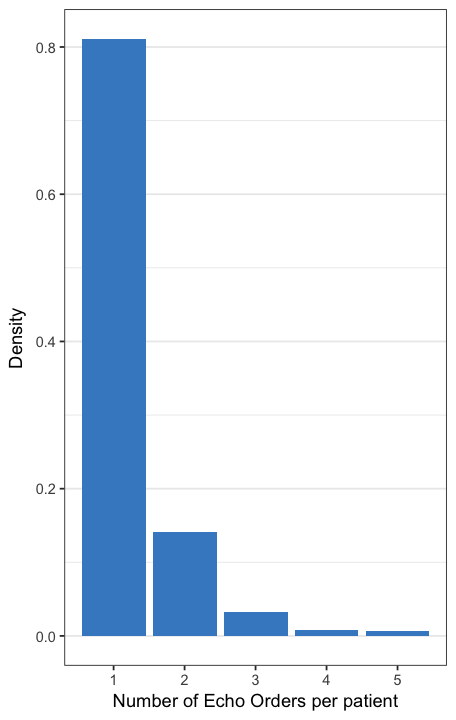

In [11]:
tte_summary %>%
filter(echo_times > 0, echo_times < 6) %>%
group_by(echo_times) %>%
summarise(freq = n()) %>%
mutate(dens = freq / sum(freq)) %>%
ggplot() +
geom_col(aes(x = echo_times, y = dens), fill = rgb(66, 139, 202, maxColorValue = 255)) +
theme_bw() +
labs(x = "Number of Echo Orders per patient",
     y = "Density") +
theme_bw() +
theme(panel.grid.minor.x = element_blank(), panel.grid.major.x = element_blank())

In [12]:
tte_summary %>%
summarise(mean = mean(echo_times),
          sd = sd(echo_times))

mean,sd
0.6544568,0.815581


In [13]:
dbDisconnect(con)
dbUnloadDriver(drv)

[1] TRUE

[1] TRUE

In [14]:
data.table::fwrite(tte_summary, file.path(data_dir, "echo_times.csv"))
data.table::fwrite(time_to_tte, file.path(data_dir, "time_to_tte.csv"))